<img src = "../../Data/bgsedsc_0.jpg">

# Project: Support Vector Machines (SVM)

## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as LOS.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test.csv*. Apply your final model to this extra dataset and submit to Kaggle competition to obtain accuracy of prediction (follow the requested format).

Try to optimize hyperparameters of your SVM model.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Test the performance on the test file by submitting to Kaggle, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

For the in-class version, feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN-CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 15%
+ Data preparation - 20%
+ SVMs method(s) have been used - 25%
+ Probability of death for each test patient is computed - 15%
+ Accuracy itself - 15%
+ Hyperparameter optimization - 10%
+ Class imbalance management - 0%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%


In [85]:
# Import libraries 

import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors 
from sklearn.model_selection import train_test_split
from helper_functions import *
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import seaborn as sns
import ipywidgets
from math import floor, ceil
import datetime as dt
from datetime import timedelta

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 
from sklearn import preprocessing
from sklearn.metrics import  r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import category_encoders as ce
import pickle
from sklearn.svm import SVC

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors 
from sklearn.model_selection import train_test_split
from helper_functions import *
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from datatile.summary.df import DataFrameSummary

# Category encoder
import category_encoders as ce
from category_encoders.woe import WOEEncoder

from sklearn.pipeline import Pipeline

## Import data

In [86]:
# Starter code to load data
import pandas as pd
# Training dataset

df_original =pd.read_csv('mimic_train.csv')
df = df_original
df.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [87]:
# Test dataset (to produce predictions)
data_test_original=pd.read_csv('mimic_test_death.csv')
data_test = data_test_original
data_test.sort_values('icustay_id').head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [88]:
# Sample output prediction file
pred_sample=pd.read_csv('mimic_kaggle_death_sample_submission.csv')
pred_sample.sort_values('icustay_id').head()

,icustay_id,HOSPITAL_EXPIRE_FLAG
1937,200011,0
4908,200044,0
829,200049,0
4378,200063,0
4946,200081,0


In [89]:
# Extra data of all comorbilities:
extra_original =pd.read_csv('MIMIC_diagnoses.csv')
extra = extra_original
extra.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


### Subsampling training data

For the **in-class** part of this project you are **recommended** to work with only a **subset of the observations** in the training data. This is because for a dataset of this size, SVM can be very very slow to fit. 

The code below will do this for you 

**Note I** you will still need a prediction for the whole testing set to get a score in Kaggle - for SVM it is training that is computationally expensive, producing predictions is (relatively) easy 

**Note II**  for the extended project you should work with the full data


## Feature creation

In [90]:
# Drop variables in training set 
df=df.drop(['LOS'], axis=1)

In [91]:
#Creating AGE variable in data train
df['Diff']=df.apply(lambda x: timedelta(days=-x.Diff),axis=1)
df['DOB'] = df.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
df['DOB'] = df.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
df['ADMITTIME'] = df.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
df['ADMITTIME'] = df.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
df['age']=df.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)

In [92]:
#Creating AGE variable in data test
data_test['Diff']=data_test.apply(lambda x: timedelta(days=-x.Diff),axis=1)
data_test['DOB'] = data_test.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
data_test['DOB'] = data_test.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
data_test['ADMITTIME'] = data_test.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
data_test['ADMITTIME'] = data_test.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
data_test['age']=data_test.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)

In [93]:
# All the ages over 90 years old (~ 32850 days) are set to more than 300 years old. Acording to  https://mimic.physionet.org/mimicdata/time/ - ages over 89 are shifted 
# such that the patient age appears to be 300 in the database.
# I will impute them as 90 years old
df['age'] = np.where(df['age'] >= 32850, 90, df['age'])
data_test['age'] = np.where(data_test['age'] >= 32850, 90, data_test['age'])

In [94]:
# Create comobilities:  Number of comorbidites in each hospital stay

num_of_comob=extra['HADM_ID'].value_counts()
df['comob']=df['hadm_id'].replace(to_replace=num_of_comob.index,value=num_of_comob.values)
data_test['comob']=data_test['hadm_id'].replace(to_replace=num_of_comob.index,value=num_of_comob.values)

In [95]:
# Calculate the probability of death using using the extra dataset considering all the diagnosis of the patients.I used the mean because is just a [0-1] values
# Then I replace it in the 'IC9-diagnosis'  
alldata = pd.merge(df,extra,how='left',left_on='hadm_id',right_on='HADM_ID')
diag_mean = alldata.groupby('ICD9_CODE').mean()['HOSPITAL_EXPIRE_FLAG']
df['ICD9_diagnosis']=df['ICD9_diagnosis'].replace(to_replace=diag_mean.index,value=diag_mean.values) #_mean
data_test['ICD9_diagnosis']=data_test['ICD9_diagnosis'].replace(to_replace=diag_mean.index,value=diag_mean.values) #_mean
data_test['ICD9_diagnosis']=pd.to_numeric(data_test['ICD9_diagnosis'])

In [96]:
# Get rid of the columns that are not going to be used anymore.

df=df.drop(['DOB','ADMITTIME','Diff','subject_id','hadm_id','icustay_id'], axis=1)
data_test=data_test.drop(['DOB','ADMITTIME','Diff','subject_id','hadm_id','icustay_id'], axis=1)


## Exploratory Analysis

In [97]:
#Select categorical variables
cat_col_train=[name for name in df.select_dtypes(exclude=np.number).columns]
num_col_train = [name for name in df.select_dtypes(np.number).columns]
cat_col_test=[name for name in data_test.select_dtypes(exclude=np.number).columns]
num_col_test = [name for name in data_test.select_dtypes(np.number).columns]


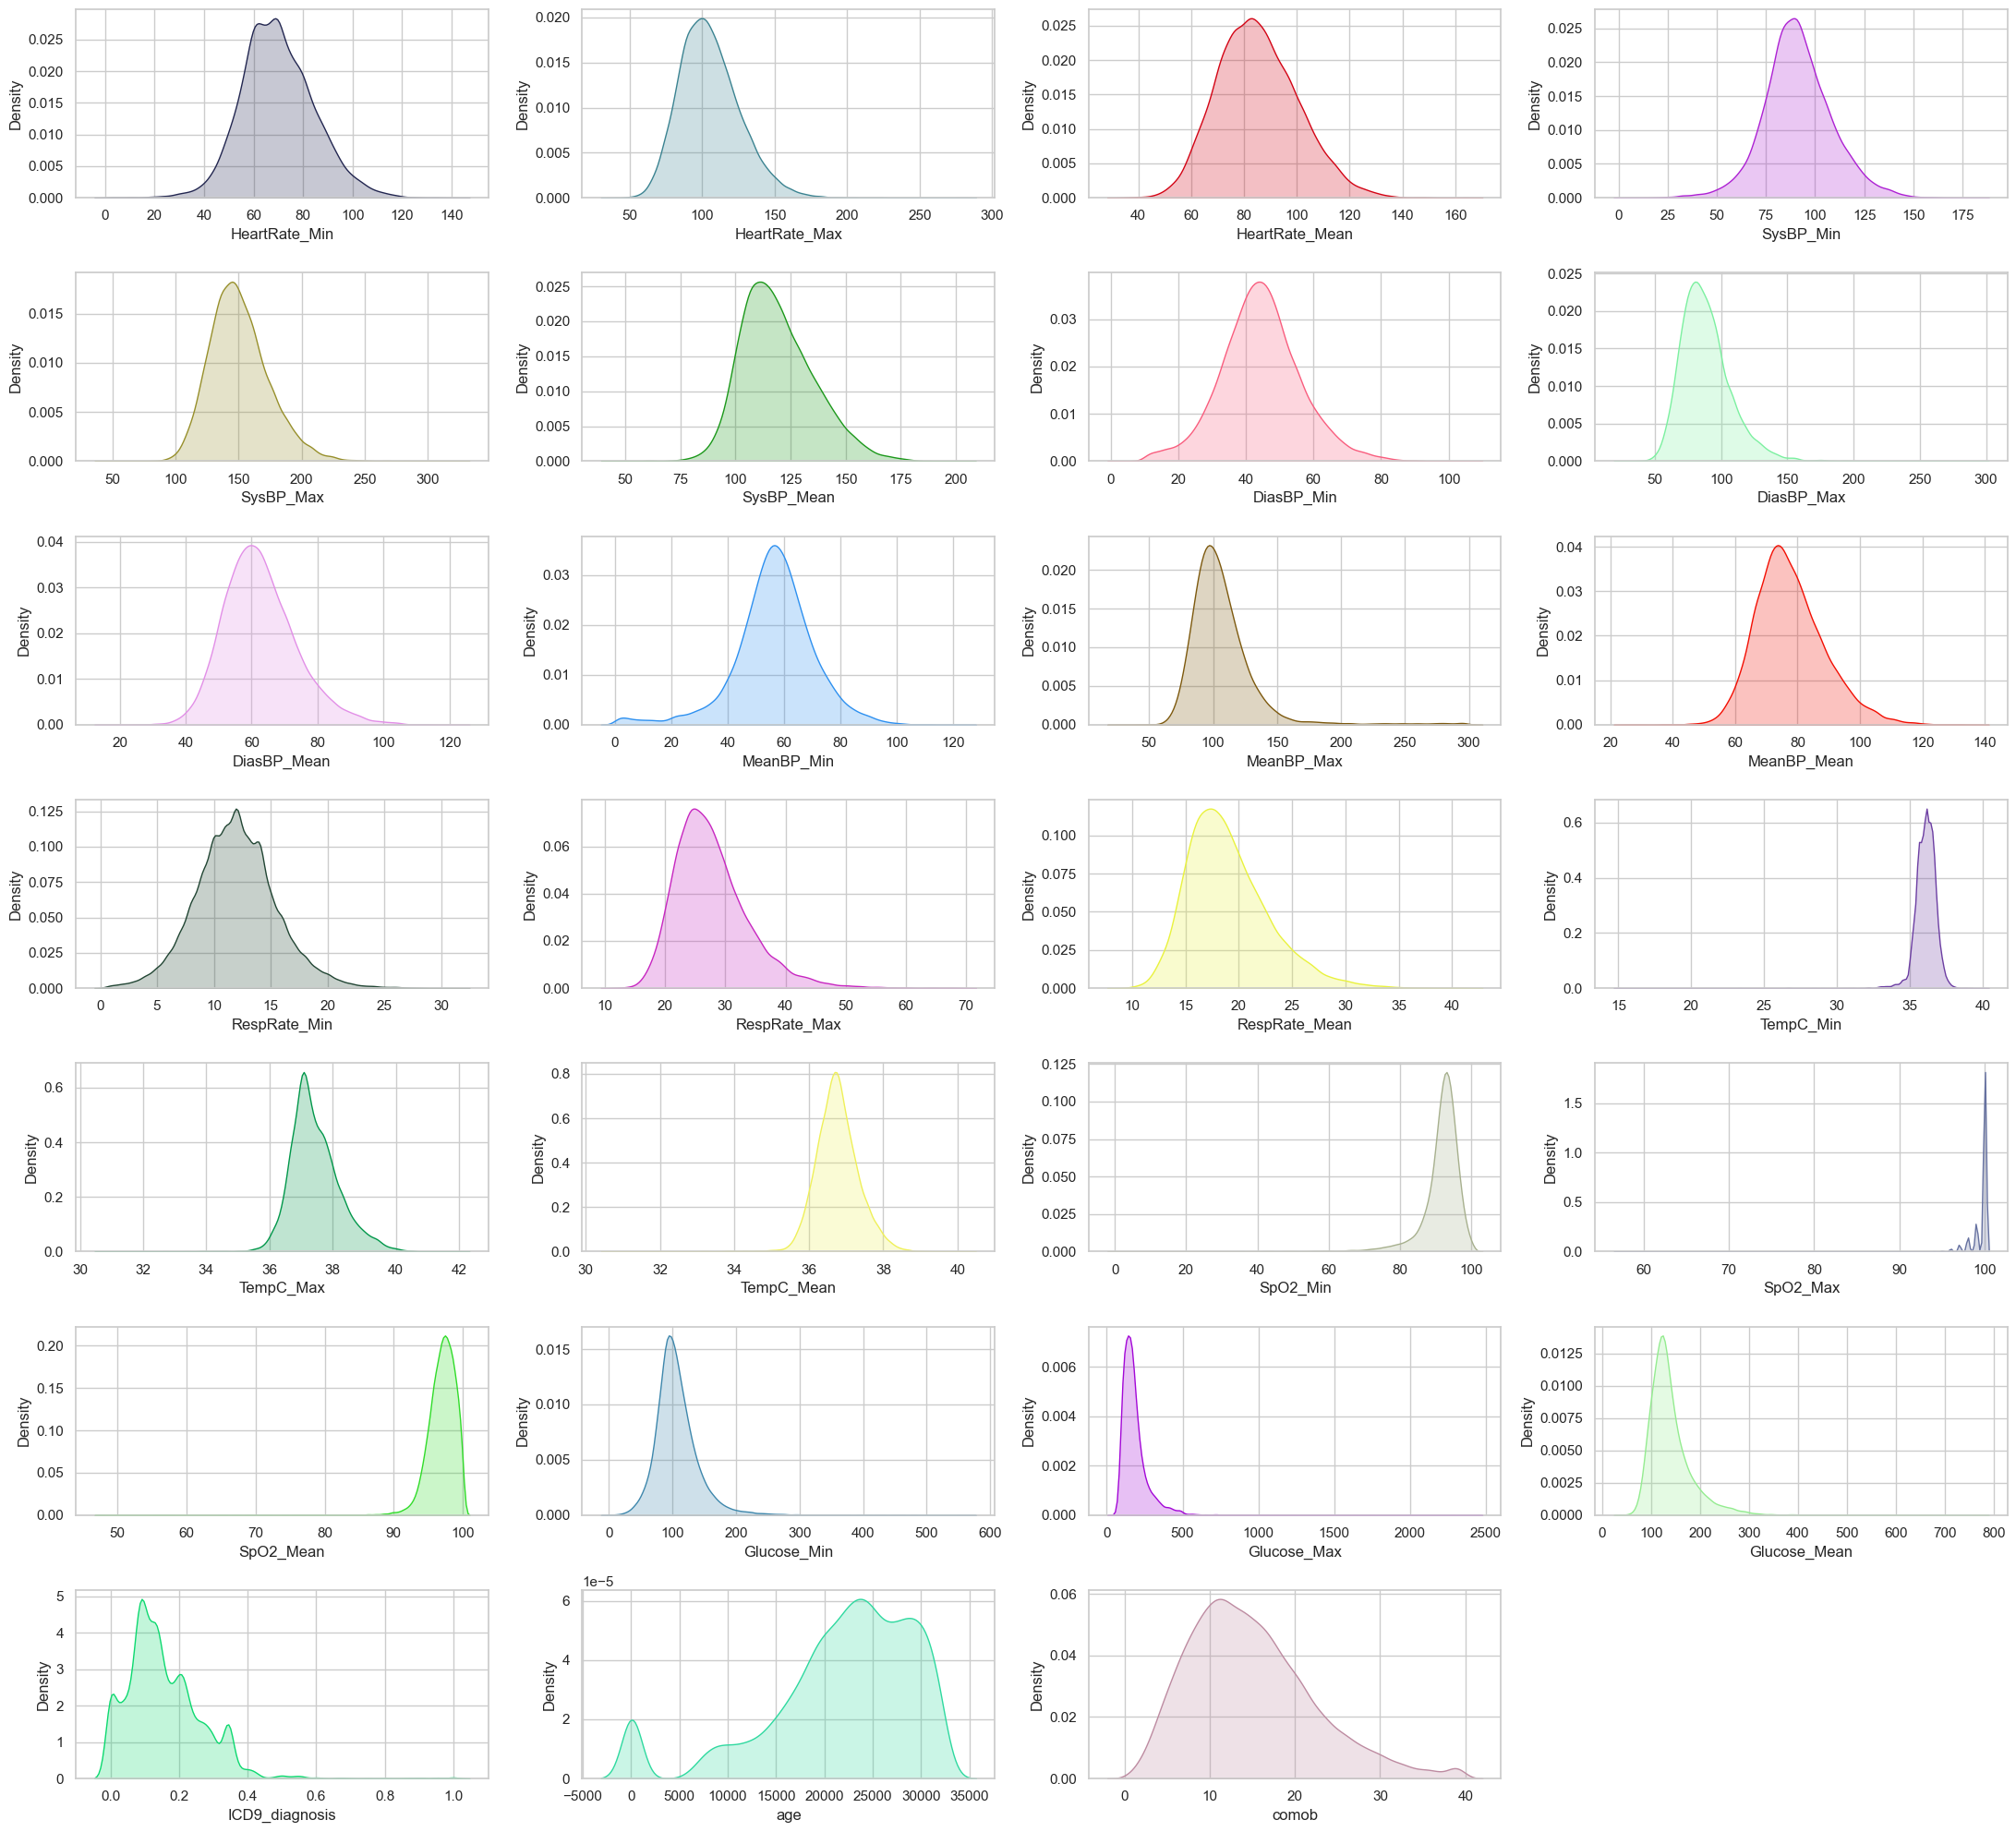

In [98]:
# Univariate kernel density distributions for continuous features
sns.set(style="whitegrid")
plt.figure(figsize=(22, 20)) # Size of the matrix plots

for i, col in enumerate(num_col_train):
  if i == 0:
    pass
  else:
    plt.subplot(7, 4, i) # row, cols and i is the element to plot
    sns.kdeplot(x = col, 
                data = df, 
                fill=True, 
                color = np.random.rand(3,) )
plt.tight_layout()

In [99]:
#Description of continuous variables  
df[num_col_train].describe()

,HOSPITAL_EXPIRE_FLAG,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,...,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,ICD9_diagnosis,age,comob
count,20885.000000,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,18676.000000,18676.000000,18676.000000,...,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000,20885.000000,20885.000000
mean,0.112282,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,44.327854,88.360784,62.511614,...,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,0.156045,21707.718937,14.838113
std,0.315720,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,11.909852,19.285554,11.010790,...,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,0.115577,7765.288829,7.301290
min,0.000000,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,4.000000,27.000000,17.000000,...,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,0.000000,90.000000,1.000000
25%,0.000000,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,37.000000,75.000000,54.950952,...,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,0.083333,18268.000000,9.000000
50%,0.000000,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,44.000000,86.000000,61.423660,...,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,0.133399,23100.000000,14.000000
75%,0.000000,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,51.000000,98.000000,68.954545,...,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,0.217391,27518.000000,19.000000
max,1.000000,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,105.000000,294.000000,121.489362,...,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,1.000000,32507.000000,39.000000


## Missing Data

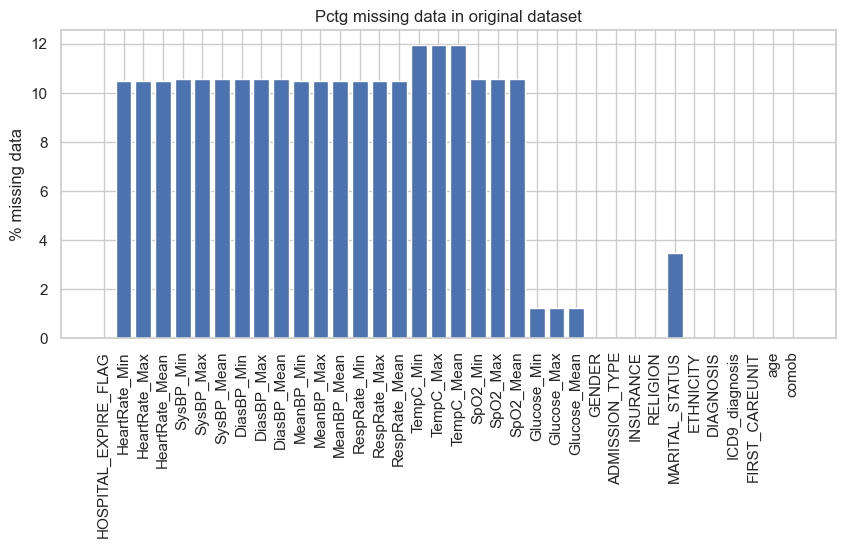

In [100]:
Nulls= df.isnull().sum()
x_vals = Nulls.index
y_vals = 100*Nulls.values/len(df.index)
plt.figure(figsize=(10,4))
plt.xticks(rotation='vertical')
plt.bar(x_vals, y_vals)
plt.ylabel('% missing data')
plt.title('Pctg missing data in original dataset')
plt.show()

## Split categorical and non categorical data

In [101]:
df_train_num = df[num_col_train]
df_test_num = data_test[num_col_test]

df_train_cat = df[cat_col_train]
df_test_cat = data_test[cat_col_test]

## Correlation 

In [102]:
#I will delete variables with abs correlation less than 0.05 with the target value
cor_matrix = df_train_num.corr().abs()
cor_matrix_hop = cor_matrix.filter(['HOSPITAL_EXPIRE_FLAG'], axis=1)
cor_matrix_hop_1 = cor_matrix_hop[cor_matrix_hop.HOSPITAL_EXPIRE_FLAG< 0.05]
cor_matrix_hop_1.reset_index(inplace=True)
delete = cor_matrix_hop_1["index"].values.tolist()
print("Columns to delete :" + str(delete))

Columns to delete :['HeartRate_Min', 'SysBP_Max', 'DiasBP_Max', 'MeanBP_Max', 'TempC_Max', 'SpO2_Max']


In [103]:
df_train_num=df_train_num.drop(delete, axis=1)
df_test_num=df_test_num.drop(delete, axis=1)

## Split target

In [104]:
y_train = df['HOSPITAL_EXPIRE_FLAG']
df_train_num = df_train_num.drop(['HOSPITAL_EXPIRE_FLAG'], axis = 1)

## Categorical variables

In [105]:
# Checking levels for each categorical variable in train set
for column in df[cat_col_train]:
    print(f"{column} : {len(df[column].value_counts())}")
#ETHNICITY and DIAGNOSIS has too many categories for one hot encoding so I will use a different method for them

GENDER : 2
ADMISSION_TYPE : 3
INSURANCE : 5
RELIGION : 17
MARITAL_STATUS : 7
ETHNICITY : 41
DIAGNOSIS : 6193
FIRST_CAREUNIT : 5


### One-hot encoding

In [106]:
#Variables with few categories for one hot encoding

one_hot_feats = ['GENDER', 'RELIGION','ADMISSION_TYPE', 'FIRST_CAREUNIT','INSURANCE','MARITAL_STATUS']
prfx_dict = {'GENDER': 'gender','RELIGION' : 'rel', 'ADMISSION_TYPE': 'admin_type','FIRST_CAREUNIT': 'firstcare','INSURANCE': 'ins', 'MARITAL_STATUS': 'mar_stat'}

df_train_dumm1 = df[one_hot_feats]
df_test_dumm1 = data_test[one_hot_feats]

df_train_dumm1_f = pd.get_dummies(df_train_dumm1, prefix=prfx_dict, columns=one_hot_feats, drop_first = True)
df_test_dumm1_f = pd.get_dummies(df_test_dumm1, prefix=prfx_dict, columns=one_hot_feats, drop_first = True)


### Target encoding

+ The main idea behind the target encoder is to encode the categories by replacing them for a measurement of the effect they might have on the target
+ I used it in variables with multiple categories
+ I also tried binary encoding and Weight of Evidence Encoding but this one has better results

In [107]:
#Define variables
cat_feats_figs = ['ETHNICITY','DIAGNOSIS']
train_te = df[cat_feats_figs]
test_te = data_test[cat_feats_figs]

#Target encoder
tenc=ce.TargetEncoder() 
tenc.fit(train_te, y_train)
df_train_dumm2_f = tenc.transform(train_te)
df_test_dumm2_f = tenc.transform(test_te)

# Print shape
print('Shape: ', df_train_dumm2_f.shape); 
print('Shape: ', df_test_dumm2_f.shape)


Shape:  (20885, 2)
Shape:  (5221, 2)


### Join dataset

In [108]:
df_train_concat = pd.concat([df_train_num, df_train_dumm1_f,df_train_dumm2_f], axis = 1)
df_test_concat = pd.concat([df_test_num, df_test_dumm1_f,df_test_dumm2_f], axis = 1)
#df_train_dumm3
#df_test_dumm3
print("Shape: " + str(df_train_concat.shape))
print("Shape: " + str(df_test_concat.shape))

Shape: (20885, 56)
Shape: (5221, 55)


In [109]:
#Align in case of having different rows
final_train, final_test = df_train_concat.align(df_test_concat, join='inner', axis=1)
print("Shape: " + str(final_train.shape))
print("Shape: " + str(final_test.shape))
df_train_concat,df_test_concat = final_train, final_test

Shape: (20885, 55)
Shape: (5221, 55)


## Standardization

In [110]:
# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Fit to train 
scaler.fit(df_train_concat)

# Transform train and test
df_train_scl = scaler.transform(df_train_concat)
df_test_scl = scaler.transform(df_test_concat)


## Imputation of Nan

+ I used Iterative imputer that is a multivariate imputing strategy that models a column with the missing values (target variable) as a function of other features (predictor variables)
+ I also tried with KNN imputer and Simple Imputer, having better results with this one

In [111]:
%%time
#Instantiate imputer
imp_nums = IterativeImputer(random_state = 0)

# Fit
imp_nums.fit(df_train_scl)

# Transform
df_train_scl_imp = imp_nums.fit_transform(df_train_scl)
df_test_scl_imp = imp_nums.transform(df_test_scl)

# Format data
X_train = pd.DataFrame(df_train_scl_imp, 
                            columns = df_train_concat.columns, 
                            index = df_train_concat.index)
X_test = pd.DataFrame(df_test_scl_imp, 
                           columns = df_test_concat.columns, 
                           index = df_test_concat.index)



Wall time: 41.8 s


In [112]:
#Check imputation in train set
print("Shape: " + str(X_train.shape))
X_train

Shape: (20885, 55)


,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Mean,DiasBP_Min,DiasBP_Mean,MeanBP_Min,MeanBP_Mean,RespRate_Min,RespRate_Max,...,ins_Private,ins_Self Pay,mar_stat_LIFE PARTNER,mar_stat_MARRIED,mar_stat_SEPARATED,mar_stat_SINGLE,mar_stat_UNKNOWN (DEFAULT),mar_stat_WIDOWED,ETHNICITY,DIAGNOSIS
0,1.900397,2.341278,-0.975958,-0.751956,-0.195461,-0.121493,0.188658,-0.275898,0.862461,0.353561,...,-0.653124,-0.09683,-0.0259,-0.928031,-0.107820,1.591804,-0.0704,-0.395018,-0.091641,-0.639741
1,0.227521,-0.395788,-0.120383,-0.743192,0.392303,0.201782,0.118964,-0.252815,0.302566,-1.079937,...,1.531103,-0.09683,-0.0259,1.077550,-0.107820,-0.628218,-0.0704,-0.395018,-0.091641,-0.278981
2,-0.346037,0.424957,-0.177421,-0.380797,0.056438,-0.516797,0.537129,-0.424786,0.302566,-1.079937,...,-0.653124,-0.09683,-0.0259,-0.928031,9.274742,-0.628218,-0.0704,-0.395018,-0.805413,-0.382684
3,1.087857,0.892876,-0.405575,-0.728843,-1.203058,-1.875188,-0.577978,-1.334091,0.022618,1.149949,...,-0.653124,-0.09683,-0.0259,-0.928031,-0.107820,-0.628218,-0.0704,2.531532,-0.091641,-0.321445
4,-0.207117,-0.344576,-0.009978,0.251660,-0.507518,-0.523331,-0.306349,-0.209936,0.066110,0.014541,...,-0.653124,-0.09683,-0.0259,-0.928031,-0.107820,-0.628218,-0.0704,2.531532,-0.091641,0.443304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,-0.632816,-0.436110,-1.774495,-0.489145,-0.867192,-0.537340,-1.065838,-0.749016,-0.537278,-0.761382,...,-0.653124,-0.09683,-0.0259,1.077550,-0.107820,-0.628218,-0.0704,-0.395018,-0.091641,0.115652
20881,0.323114,0.259567,0.507039,0.247128,1.148000,0.481955,1.234071,0.427796,-0.817226,-0.602105,...,1.531103,-0.09683,-0.0259,1.077550,-0.107820,-0.628218,-0.0704,-0.395018,-1.687026,-0.485515
20882,-0.393833,-0.538388,0.164809,-0.425625,0.896101,0.441284,0.676517,0.080128,0.582513,-0.124272,...,1.531103,-0.09683,-0.0259,-0.928031,-0.107820,-0.628218,-0.0704,-0.395018,-0.805413,-0.397057
20883,-0.154851,-0.217773,0.278885,0.280928,0.224370,-0.206989,0.606823,-0.155297,0.862461,-0.124272,...,-0.653124,-0.09683,-0.0259,-0.928031,-0.107820,-0.628218,-0.0704,2.531532,-0.091641,-0.259898


In [113]:
#Check imputation in test set
print("Shape: " + str(X_test.shape))
X_test

Shape: (5221, 55)


,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Mean,DiasBP_Min,DiasBP_Mean,MeanBP_Min,MeanBP_Mean,RespRate_Min,RespRate_Max,...,ins_Private,ins_Self Pay,mar_stat_LIFE PARTNER,mar_stat_MARRIED,mar_stat_SEPARATED,mar_stat_SINGLE,mar_stat_UNKNOWN (DEFAULT),mar_stat_WIDOWED,ETHNICITY,DIAGNOSIS
0,-0.728408,0.004220,-0.804843,-1.236719,-0.363394,-0.953039,-0.229507,-0.846714,-1.657069,-0.602105,...,-0.653124,-0.09683,-0.0259,1.077550,-0.10782,-0.628218,-0.0704,-0.395018,-0.091641,-1.236501
1,1.900397,1.950365,-1.032997,-1.073878,-0.195461,0.278583,-0.438590,0.665029,2.262201,1.946337,...,1.531103,-0.09683,-0.0259,1.077550,-0.10782,-0.628218,-0.0704,-0.395018,-0.091641,-1.236501
2,1.279043,2.126268,0.107770,-0.175031,0.560236,0.380736,0.258352,-0.023700,1.142409,-0.124272,...,-0.653124,-0.09683,-0.0259,1.077550,-0.10782,-0.628218,-0.0704,-0.395018,-0.091641,-0.048459
3,-0.011462,-0.101394,-1.090035,0.469216,-0.447360,0.031146,-0.717367,0.080128,-0.537278,-0.283549,...,1.531103,-0.09683,-0.0259,-0.928031,-0.10782,-0.628218,-0.0704,2.531532,-0.091641,-0.259898
4,0.896671,0.876089,-0.291498,-0.507678,0.644202,0.937444,0.676517,0.792507,-1.377122,0.194284,...,-0.653124,-0.09683,-0.0259,-0.928031,-0.10782,1.591804,-0.0704,-0.395018,-0.091641,-0.048459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,1.231246,0.780150,0.963346,0.208739,0.392303,0.010895,0.676517,-0.181886,1.142409,0.831394,...,-0.653124,-0.09683,-0.0259,-0.928031,-0.10782,1.591804,-0.0704,-0.395018,-0.091641,0.286372
5217,-0.158178,-0.091574,-0.333225,-0.199763,-0.068342,-0.397149,0.008788,-0.137132,-0.562323,0.054691,...,-0.653124,-0.09683,-0.0259,1.077550,-0.10782,-0.628218,-0.0704,-0.395018,-0.091641,-0.137871
5218,-0.680612,-0.241019,1.476691,1.452000,0.308337,0.154188,0.676517,0.562488,-1.097174,-0.283549,...,-0.653124,-0.09683,-0.0259,-0.928031,-0.10782,-0.628218,-0.0704,2.531532,0.281830,-0.048459
5219,-0.776205,-0.320128,-1.318188,-0.506829,-0.195461,-0.618454,-0.508284,-0.585184,-1.097174,-0.761382,...,-0.653124,-0.09683,-0.0259,-0.928031,-0.10782,-0.628218,-0.0704,-0.395018,-0.091641,-0.048459


## SVM

In [114]:
# I tried a lot of times without spliting the data but wasn't possible I tried three differents nights without results. 
# So I generate a sample of 10% of the data for fit the parameters and then run them in the all sample.

### Sample generation

In [115]:
# Concatenate train set to generate the sample
df_prov = pd.concat([X_train, y_train], axis = 1)
df_prov

,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Mean,DiasBP_Min,DiasBP_Mean,MeanBP_Min,MeanBP_Mean,RespRate_Min,RespRate_Max,...,ins_Self Pay,mar_stat_LIFE PARTNER,mar_stat_MARRIED,mar_stat_SEPARATED,mar_stat_SINGLE,mar_stat_UNKNOWN (DEFAULT),mar_stat_WIDOWED,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG
0,1.900397,2.341278,-0.975958,-0.751956,-0.195461,-0.121493,0.188658,-0.275898,0.862461,0.353561,...,-0.09683,-0.0259,-0.928031,-0.107820,1.591804,-0.0704,-0.395018,-0.091641,-0.639741,0
1,0.227521,-0.395788,-0.120383,-0.743192,0.392303,0.201782,0.118964,-0.252815,0.302566,-1.079937,...,-0.09683,-0.0259,1.077550,-0.107820,-0.628218,-0.0704,-0.395018,-0.091641,-0.278981,0
2,-0.346037,0.424957,-0.177421,-0.380797,0.056438,-0.516797,0.537129,-0.424786,0.302566,-1.079937,...,-0.09683,-0.0259,-0.928031,9.274742,-0.628218,-0.0704,-0.395018,-0.805413,-0.382684,0
3,1.087857,0.892876,-0.405575,-0.728843,-1.203058,-1.875188,-0.577978,-1.334091,0.022618,1.149949,...,-0.09683,-0.0259,-0.928031,-0.107820,-0.628218,-0.0704,2.531532,-0.091641,-0.321445,0
4,-0.207117,-0.344576,-0.009978,0.251660,-0.507518,-0.523331,-0.306349,-0.209936,0.066110,0.014541,...,-0.09683,-0.0259,-0.928031,-0.107820,-0.628218,-0.0704,2.531532,-0.091641,0.443304,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,-0.632816,-0.436110,-1.774495,-0.489145,-0.867192,-0.537340,-1.065838,-0.749016,-0.537278,-0.761382,...,-0.09683,-0.0259,1.077550,-0.107820,-0.628218,-0.0704,-0.395018,-0.091641,0.115652,0
20881,0.323114,0.259567,0.507039,0.247128,1.148000,0.481955,1.234071,0.427796,-0.817226,-0.602105,...,-0.09683,-0.0259,1.077550,-0.107820,-0.628218,-0.0704,-0.395018,-1.687026,-0.485515,0
20882,-0.393833,-0.538388,0.164809,-0.425625,0.896101,0.441284,0.676517,0.080128,0.582513,-0.124272,...,-0.09683,-0.0259,-0.928031,-0.107820,-0.628218,-0.0704,-0.395018,-0.805413,-0.397057,0
20883,-0.154851,-0.217773,0.278885,0.280928,0.224370,-0.206989,0.606823,-0.155297,0.862461,-0.124272,...,-0.09683,-0.0259,-0.928031,-0.107820,-0.628218,-0.0704,2.531532,-0.091641,-0.259898,0


In [116]:
#Sample generation 

from numpy import random 

random.seed(10)
n_subset = 2000
ind_subset = random.choice(df_prov.shape[0], size= n_subset, replace=False)## indicies of your sampled points

data_subset = df_prov.copy().iloc[ind_subset,]## selecting the subsampled indicies
data_subset.shape

X_train_sample = df_prov.drop(['HOSPITAL_EXPIRE_FLAG'], axis = 1)
y_train_sample = df_prov['HOSPITAL_EXPIRE_FLAG']

### Instantiate classifier

In [117]:
# Set pipeline with the possible parameters
# I set and tried different alternatives for the parameters in the following lines.

SVC = SVC()

# Set params

C = [0.1, 1, 10]
gamma = [0.25, 0.5, 0.75]
kernel =  ['rbf','linear', 'poly']
probability =  [True]
class_weight = ['balanced']


# Set pipeline
pipe = Pipeline(steps=[("SVC", SVC)])

params = dict(SVC__C = C,
              SVC__gamma = gamma,
              SVC__kernel = kernel,
              SVC__probability = probability,
              SVC__class_weight= class_weight
             )

In [41]:
%%time 

#Gridsearch
#I will not run this cell again, for the time
import warnings; warnings.filterwarnings("ignore")

# Print of NN candidates
print("C Candidates: " + str(C))
print("Gamma Candidates: " + str(gamma))
print("Kernel Candidates: " + str(kernel))
print("Probability Candidates: " + str(probability))

# Instantiate grid search and pipe. RandomizedSearchCV() is used to save computing time compared to GridSearchCV()
svc_grid = GridSearchCV(estimator = pipe,
                         param_grid = params,
                         scoring ='roc_auc',
                         cv = 5,
                         #n_iter = 25,
                         n_jobs = -1,
                         verbose = 3)


# Run grid search
svc_grid.fit(X_train_sample, y_train_sample) 


C Candidates: [0.1, 1, 10]
Gamma Candidates: [0.25, 0.5, 0.75]
Kernel Candidates: ['rbf', 'linear', 'poly']
Probability Candidates: [True]
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Wall time: 9h 52min 13s


GridSearchCV(cv=5, estimator=Pipeline(steps=[('SVC', SVC())]), n_jobs=-1,
             param_grid={'SVC__C': [0.1, 1, 10],
                         'SVC__class_weight': ['balanced'],
                         'SVC__gamma': [0.25, 0.5, 0.75],
                         'SVC__kernel': ['rbf', 'linear', 'poly'],
                         'SVC__probability': [True]},
             scoring='roc_auc', verbose=3)

In [118]:
# Save best parameters
best_C = svc_grid.best_estimator_.get_params()['SVC__C']
best_gamma = svc_grid.best_estimator_.get_params()['SVC__gamma']
best_kernel = svc_grid.best_estimator_.get_params()['SVC__kernel']
best_prob = svc_grid.best_estimator_.get_params()['SVC__probability']

print(svc_grid.best_params_ )

{'SVC__C': 0.1, 'SVC__class_weight': 'balanced', 'SVC__gamma': 0.25, 'SVC__kernel': 'linear', 'SVC__probability': True}


best parameters: {'SVC__C': 0.1, 'SVC__class_weight': 'balanced', 'SVC__gamma': 0.25, 'SVC__kernel': 'linear', 'SVC__probability': True}
best score:      0.87532 (+/-0.00585)


,param_SVC__C,param_SVC__class_weight,param_SVC__gamma,param_SVC__kernel,param_SVC__probability,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.1,balanced,0.25,linear,True,"{'SVC__C': 0.1, 'SVC__class_weight': 'balanced...",0.877693,0.866777,0.870856,0.883481,0.877818,0.875325,0.005855,1
4,0.1,balanced,0.5,linear,True,"{'SVC__C': 0.1, 'SVC__class_weight': 'balanced...",0.877693,0.866777,0.870856,0.883481,0.877818,0.875325,0.005855,1
7,0.1,balanced,0.75,linear,True,"{'SVC__C': 0.1, 'SVC__class_weight': 'balanced...",0.877693,0.866777,0.870856,0.883481,0.877818,0.875325,0.005855,1
13,1,balanced,0.5,linear,True,"{'SVC__C': 1, 'SVC__class_weight': 'balanced',...",0.876435,0.866726,0.870588,0.883547,0.877818,0.875023,0.005848,4
16,1,balanced,0.75,linear,True,"{'SVC__C': 1, 'SVC__class_weight': 'balanced',...",0.876435,0.866726,0.870588,0.883547,0.877818,0.875023,0.005848,4
10,1,balanced,0.25,linear,True,"{'SVC__C': 1, 'SVC__class_weight': 'balanced',...",0.876435,0.866726,0.870588,0.883547,0.877818,0.875023,0.005848,4
22,10,balanced,0.5,linear,True,"{'SVC__C': 10, 'SVC__class_weight': 'balanced'...",0.876168,0.866758,0.870579,0.883533,0.877842,0.874976,0.005826,7
19,10,balanced,0.25,linear,True,"{'SVC__C': 10, 'SVC__class_weight': 'balanced'...",0.876168,0.866758,0.870579,0.883533,0.877842,0.874976,0.005826,7
25,10,balanced,0.75,linear,True,"{'SVC__C': 10, 'SVC__class_weight': 'balanced'...",0.876168,0.866758,0.870579,0.883533,0.877842,0.874976,0.005826,7
0,0.1,balanced,0.25,rbf,True,"{'SVC__C': 0.1, 'SVC__class_weight': 'balanced...",0.789562,0.781226,0.783372,0.783400,0.781994,0.783911,0.002945,10


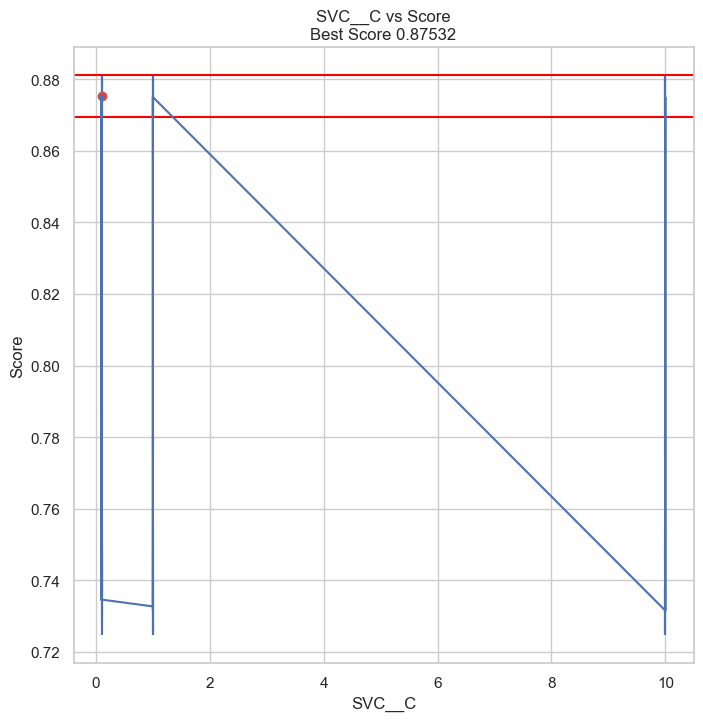

In [119]:
#Gridseach table for review teh detail fo the grid search and the best score 
GridSearch_table_plot(svc_grid, "SVC__C", negative=False, display_all_params=False)

In [120]:
%%time
#Running the model with the optimal parameters

from sklearn.svm import SVC

# Print hyperparameters from grid search
print('Best C: ' + str(best_C)); print('Best Gamma: ' + str(best_gamma)); 
print('Best Kernel: ' + str(best_kernel)); print('Best Probability: ' + str(best_prob))

# Instantiate
svc = SVC(C = best_C,
          gamma = best_gamma,
          kernel = best_kernel,
          probability = True,
         class_weight = 'balanced')

# Fit (using oversampled data)
#svc.fit(X_pca_ros, y_pca_ros)
svc.fit(X_train, y_train) 

Best C: 0.1
Best Gamma: 0.25
Best Kernel: linear
Best Probability: True
Wall time: 1min 18s


SVC(C=0.1, class_weight='balanced', gamma=0.25, kernel='linear',
    probability=True)

In [121]:
#Computing different evaluation metrics in the train set.
insample_y_pred_acc = svc.predict(X_train)

print('Accuracy Score : ' + str(accuracy_score(y_train,insample_y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_train,insample_y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_train,insample_y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_train,insample_y_pred_acc)))

Accuracy Score : 0.828202058893943
Precision Score : 0.37962424946736395
Recall Score : 0.835820895522388
F1 Score : 0.5221097496004262


In [122]:
#Generating the prediction using predict_proba
y_pred = svc.predict_proba(X_test)
y_hat_test= pd.Series(y_pred[:,1])

In [123]:
## Function for the correction factor: 
def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "icustay_id"'s and the other with your predicted "HOSPITAL_EXPIRE_FLAG" for that observation

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [124]:
# Reweight and save
q1 = ((y_train+1)/2).sum()/len(y_train)
r1 = 0.5


reweighted_outsample_pred_res = pd.DataFrame({"icustay_id": data_test_original["icustay_id"], 'HOSPITAL_EXPIRE_FLAG': pd.Series(svc.predict_proba(X_test)[:,1]).apply(reweight,args=(q1,r1))})
reweighted_outsample_pred_res.to_csv("test_predictions_SVM_VicenteLisboa.csv", index = False)